In [9]:
# loading cifar 10 dataset
import torch
import torchvision
import torchvision.transforms as transforms


In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

In [11]:
# Load the dataset with transformations applied
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
# Mean and standard deviation used during normalization
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])


In [13]:
# Function to unnormalize the image
def unnormalize(img):
    img = img * std[None, None, :] + mean[None, None, :]  # Undo normalization
    return img

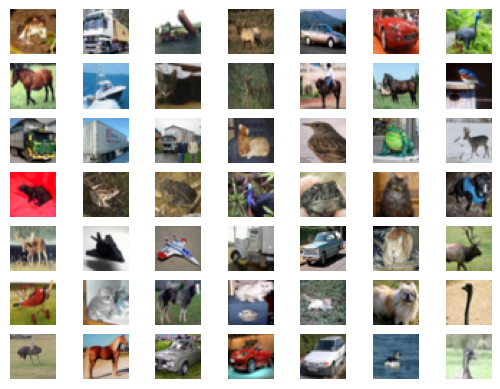

In [14]:

# Visualizing the images

import matplotlib.pyplot as plt
import numpy as np
for i in range(49):
    plt.subplot(7, 7, 1 + i)
    plt.axis('off')  # Turn off the axis
    image, label = trainset[i]  # Access image and label from the dataset
    image = image.numpy()  # Convert the image tensor to a NumPy array
    image = np.transpose(image, (1, 2, 0))  # Change the order of dimensions (C, H, W) -> (H, W, C)
    image = unnormalize(image)  # Unnormalize the image
    plt.imshow(image)

plt.show()


In [16]:
# Access one image and print its shape
image, label = trainset[0]  # Get the first image and label from the dataset
print("Shape of one image in trainset (C, H, W):", image.shape)
# Print the total number of images in the trainset
print("Total number of images in trainset:", len(trainset))


Shape of one image in trainset (C, H, W): torch.Size([3, 32, 32])
Total number of images in trainset: 50000


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)  # Input: (3, 32, 32), Output: (64, 16, 16)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # Output: (128, 8, 8)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)  # Output: (256, 4, 4)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)  # Output: (512, 2, 2)
        
        # Fully connected layer
        self.fc = nn.Linear(512 * 2 * 2, 1)  # Flattened size of conv4 output

    def forward(self, x):
        # Apply convolutional layers with LeakyReLU activation
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        
        # Flatten the output
        x = x.view(x.size(0), -1)  # Flatten the tensor for fully connected layer
        
        # Apply the final fully connected layer and Sigmoid activation
        x = torch.sigmoid(self.fc(x))  # Output: probability of the image being real
        
        return x

In [19]:
from torchsummary import summary
# Create an instance of the discriminator
discriminator = Discriminator()

# Print a detailed summary of the model architecture
summary(discriminator, input_size=(3, 32, 32))  # CIFAR-10 images have size (3, 32, 32)

# Get a batch of real images from the trainloader (CIFAR-10 dataset)
real_images, labels = next(iter(trainloader))  # Get a batch of real images

# Forward pass through the discriminator
output = discriminator(real_images)

print(output.shape)  # Output will be (batch_size, 1), indicating real/fake probabilities for each image


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,136
            Conv2d-2            [-1, 128, 8, 8]         131,200
            Conv2d-3            [-1, 256, 4, 4]         524,544
            Conv2d-4            [-1, 512, 2, 2]       2,097,664
            Linear-5                    [-1, 1]           2,049
Total params: 2,758,593
Trainable params: 2,758,593
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.23
Params size (MB): 10.52
Estimated Total Size (MB): 10.77
----------------------------------------------------------------
torch.Size([4, 1])


In [20]:
import torch
from torchviz import make_dot

# Create an instance of the discriminator
discriminator = Discriminator()

# Generate a batch of random inputs (CIFAR-10 size: 3, 32, 32)
input_tensor = torch.randn(1, 3, 32, 32)

# Perform a forward pass to generate the computational graph
output = discriminator(input_tensor)

# Use torchviz to visualize the model
make_dot(output, params=dict(discriminator.named_parameters())).render("discriminator_architecture", format="png")


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH